In [34]:
import os
import sentencepiece as spm
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd

## 데이터 준비 

In [57]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 중복, 결측치 제거 

In [58]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

test_data =test_data.dropna(axis = 0)

In [59]:
# sampling
raw = list(train_data['document']) + list(test_data['document'])
print("Data Size:", len(raw))
list(map(str, raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 195339
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..


## 데이터 분석 

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


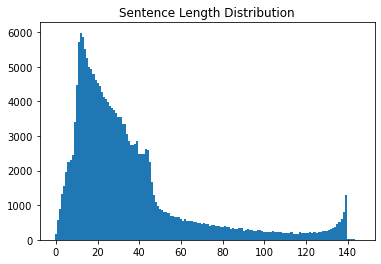

In [60]:
# data distribution
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    if type(sen) == type(1.0):
        print(sen)
    sen = str(sen)
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    #sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [61]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 20: return

check_sentence_with_length(raw, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬


In [62]:
for idx, _sum in enumerate(sentence_length):
    # # 문장 내 단어의 개수가 1500을 초과하는 인덱스를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 36


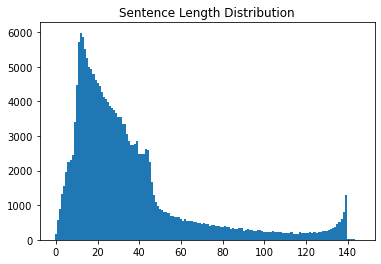

In [63]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 데이터 분할 

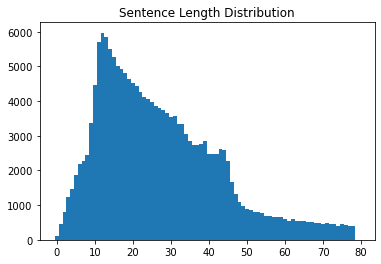

In [64]:
max_len = 80
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sen = str(sen)
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## SentencePiece 모델 학습 

In [65]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 aiffel-dj16 aiffel-dj16 414123  4월 13 22:03 korean_spm.model
-rw-r--r-- 1 aiffel-dj16 aiffel-dj16 185330  4월 13 22:03 korean_spm.vocab


## SentencePiece 토크나이저 함수 

In [66]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [67]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 490 3218   14 1234 2038    4    0    0    0    0]
 [1540 2051  215  649   10    3   17 9939 1016    7]]


In [68]:

data_set, word_index, index_word = sp_tokenize(s, raw)

In [69]:
tensor

array([[ 490, 3218,   14, 1234, 2038,    4,    0,    0,    0,    0],
       [1540, 2051,  215,  649,   10,    3,   17, 9939, 1016,    7]],
      dtype=int32)

In [70]:
data_set.shape

(195339, 132)

In [71]:
X_train = data_set[:146182]
X_test = data_set[146182:]

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 132)
(96182,)


In [72]:
print("X_train 크기 : ",X_train.shape)
print("X_test 크기 : ",len(X_test))
print("y_train 크기 : ",y_train.shape)
print("y_test 크기 : ",len(y_test))

X_train 크기 :  (146182, 132)
X_test 크기 :  49157
y_train 크기 :  (146182,)
y_test 크기 :  49157


In [73]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 50  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(word_vector_dim))#RNN에서의 대표적인 layer이다.
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid')) 
model = model_RNN

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 408       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 520,617
Trainable params: 520,617
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 5s 24ms/step - loss: 0.6931 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 2/5
188/188 [==============================] - 4s 23ms/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5011
Epoch 3/5
188/188 [==============================] - 4s 23ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 4/5
188/188 [==============================] - 4s 23ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.5011
Epoch 5/5
188/188 [==============================] - 4s 23ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5011


In [75]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.6932 - accuracy: 0.4973
[0.6931813955307007, 0.4973045587539673]


## 다른 토크나이저 (Mecab)

In [21]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

In [22]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#stopword는 각 조사로, 의미를 가지지는 않으나 단어별로 구분하는 기준으로 적절하다

def load_data(train_data, test_data, num_words=10000):#load data - raw한 텍스트 파일을 처리할 수 있게 끔 정제, 필요한 데이터를 불러온다
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 가지고 있는 단어나 stopword에 포함되어있지 않으면
                                                                    #제거해준다 !
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
nsmc = load_data(train_data, test_data)

In [23]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [24]:
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [25]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [26]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post
                                                      maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [27]:
# validation set 10000건 분리
x_val = x_train[:250]   
y_val = y_train[:250]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[250:]  
partial_y_train = y_train[250:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(145932, 41)
(145932,)


In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(8))#RNN에서의 대표적인 layer이다.
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid')) 
model = model_RNN

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
286/286 [==============================] - 2s 6ms/step - loss: 0.4662 - accuracy: 0.7903 - val_loss: 0.3701 - val_accuracy: 0.8520
Epoch 2/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3315 - accuracy: 0.8593 - val_loss: 0.3544 - val_accuracy: 0.8320
Epoch 3/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3132 - accuracy: 0.8678 - val_loss: 0.3453 - val_accuracy: 0.8480
Epoch 4/5
286/286 [==============================] - 1s 5ms/step - loss: 0.3004 - accuracy: 0.8740 - val_loss: 0.3385 - val_accuracy: 0.8360
Epoch 5/5
286/286 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8780 - val_loss: 0.3466 - val_accuracy: 0.8520


In [31]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3459 - accuracy: 0.8501
[0.34588751196861267, 0.8500518798828125]


## 회고 

형태소 기반 토크나이저인 Mecabs는 accuracy 0.85 가량, WordPiece 기반 토크나이저 SentencePiece는 accuracy 0.49 가량을 나타내며 학습이 끝났다. WPM의 기반이 되는 Byte Pair Encoding 알고리즘이 OOV의 문제와 좀 더 강건한 모델이고 이를 개선한 것이 WPM인 것으로 알고 있었는데, 생각보다 더 좋지 못한 결과가 나왔다. 다른 사람의 구현도 참고해보며 전처리를 시도했어서, 전처리 과정에서 잘못되기 보다는 Sentence Piece 모델 학습과정에서 다소 오류가 있었지 않았을까 싶다. Mecab을 통해서 토크나이징을 진행할 때 는 input으로 raw한 텍스트를, output으로는 토큰화된 텍스트를 내었는데 반해 WPM을 구현할 때는 output이 tensor형이 였던 것에서 어려움이 있었다. (물론 DecodeAsId, encode_as_piece 등의 내장 함수를 사용하면 같은 형태의 output을 낼 수 있었을 것이다.) 처음보는 토크나이징 모델로 생소했기 때문에, 좀 더 그 원리에 대해서 파악할 필요가 있다고 생각됐다. BPE나, WPM이나 모두 흥미로운 토큰화 방식이었다.